In [1]:
!wget -nc 'https://raw.githubusercontent.com/Jegovila/SSPIA1/main/10%20Proyecci%C3%B3n%20de%20imagen/A.bmp'
!wget -nc 'https://raw.githubusercontent.com/Jegovila/SSPIA1/main/10%20Proyecci%C3%B3n%20de%20imagen/B.bmp'

import cv2
import numpy as np
import matplotlib.pyplot as plt
import imutils

--2023-11-02 14:24:02--  https://raw.githubusercontent.com/Jegovila/SSPIA1/main/10%20Proyecci%C3%B3n%20de%20imagen/A.bmp
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2986030 (2.8M) [image/bmp]
Saving to: ‘A.bmp’

A.bmp               100%[===================>]   2.85M  10.5MB/s    in 0.3s    

2023-11-02 14:24:04 (10.5 MB/s) - ‘A.bmp’ saved [2986030/2986030]

--2023-11-02 14:24:04--  https://raw.githubusercontent.com/Jegovila/SSPIA1/main/10%20Proyecci%C3%B3n%20de%20imagen/B.bmp
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 286

# Funciones

## Extraer puntos

In [2]:
def Extraer_Puntos(ImgA, ImgB):
    akaze = cv2.AKAZE_create()
    kpts1, desc1 = akaze.detectAndCompute(ImgA, None)
    kpts2, desc2 = akaze.detectAndCompute(ImgB, None)

    matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_BRUTEFORCE_HAMMING)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING)
    nn_matches = matcher.knnMatch(desc1, desc2, 2)

    good = []
    for m, n in nn_matches:
        if m.distance < 0.1 * n.distance:
            good.append([m])
    #im3 = cv2.drawMatchesKnn(ImgA, kpts1, ImgB, kpts2, good[:600], None, flags=2)
    #cv2.imshow("AKAZE matching", im3)
    #cv2.waitKey(0)

    pointsImgA = np.empty([len(good), 2])
    pointsImgB = np.empty([len(good), 2])

    for i in range(len(good)):
        pointsImgA[i, :] = kpts1[good[i][0].queryIdx].pt
        pointsImgB[i, :] = kpts2[good[i][0].trainIdx].pt

    return pointsImgA[:600], pointsImgB[:600]

## Desplegar imágenes

In [3]:

def plot_images(*imgs, figsize=(10,5), hide_ticks=False):
    '''Display one or multiple images.'''
    f = plt.figure(figsize=figsize)
    width = np.ceil(np.sqrt(len(imgs))).astype('int')
    height = np.ceil(len(imgs) / width).astype('int')
    for i, img in enumerate(imgs, 1):
        ax = f.add_subplot(height, width, i)
        if hide_ticks:
            ax.axis('off')
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

## Crear Panorama

In [4]:
def Crear_Figura_Panoramica(ImgA, ImgB, T):
    dim_x = ImgA.shape[0] + ImgB.shape[0]
    dim_y = ImgA.shape[1] + ImgB.shape[1]
    dim = (dim_x, dim_y)

    warped = cv2.warpPerspective(ImgB, T, dim)

    #plot_images(warped)
    comb = warped.copy()

    # combinar las dos imagenes
    comb[0:ImgA.shape[0], 0:ImgA.shape[1]] = ImgA

    # crop (Recortar al tamaño de la imagen de salida)
    gray = cv2.cvtColor(comb, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]

    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    c = max(cnts, key=cv2.contourArea)

    (x, y, w, h) = cv2.boundingRect(c)

    comb = comb[y:y + h, x:x + w]
    plot_images(comb)
    plt.show()

## Construir Matriz de transformación

In [5]:
def Construir_Matriz_Transformacion(x):
    T = np.array([[x[0], x[1], x[2]], [x[3], x[4], x[5]], [x[6], x[7], x[8]]])
    return T

## Cálculo del error

In [6]:
def Calcular_Errores(pA, ppB):
    ppB = ppB.transpose()
    e = np.sqrt((pA[:, 0] - ppB[:, 0]) ** 2 + (pA[:, 1] - ppB[:, 1]) ** 2)
    return e

## Transformar Puntos

In [7]:
def Transformar_Puntos(p, T):
    p2 = np.empty([len(p), 2])
    for i in range(len(p)):
        p2[i, :] = p[i]

    P = np.concatenate((p2, np.ones([len(p),1])),1) @ T.transpose()
    pp = np.array([P[:, 0] / P[:, 2], P[:, 1] / P[:, 2]])

    return pp

# Algoritmo

Leer imágenes y extraer puntos de interés

In [8]:
ImgA = cv2.imread('A.bmp')
ImgB = cv2.imread('B.bmp')

pA, pB = Extraer_Puntos(ImgA, ImgB)

Parámetros

In [9]:
M = len(pB)
l =0.5  # <--- REGULACIÓN

G =100
N =80

F =0.2
CR =0.8

xl = np.array([-8,-8,-8,
               -6,-6,-6,
               -4,-4,-4])
xu = np.array([9,9,9,
               5,5,5,
               3,3,3])
D = len(xl)

x = np.zeros((D, N))
fitness = np.zeros(N)

fx_plot = np.zeros(G)

Algoritmo de optimización

[[ 2.10283673  0.1627116  -0.04174115]
 [ 3.7678692   1.70095334 -1.98311278]
 [-2.4119497  -0.93656801  0.94850466]]


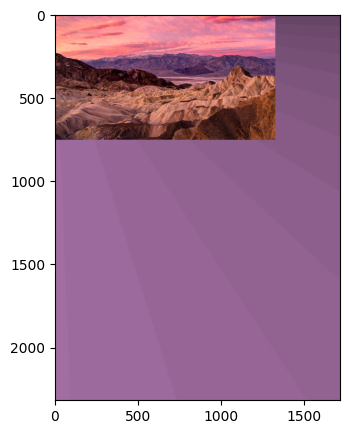

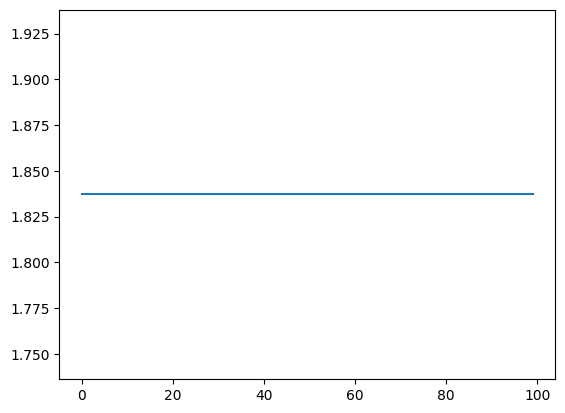

In [15]:
for i in range(N):
    x[:, i] = xl + (xu - xl) * np.random.rand(D)

    T = Construir_Matriz_Transformacion(xu)                # <------ Completar argumentos
    ppB = Transformar_Puntos(pB,T)                           # <------ Completar argumentos
    e = Calcular_Errores(pA,ppB)                               # <------ Completar argumentos

    fitness[i] = l * (1/D) * np.sum(x[:,i] ** 2)    # <------ Completar fitness

for n in range(G):
    for i in range(N):
        # Mutación

        # Estas dos lineas son de ayuda para seleccionar los vectores r1, r2 y r3 (recordar que deben ser diferentes)
        # necesarios para el cálculo de "v" en Evolución Diferencial
        I = np.random.permutation(N) # Esta línea hace una permutación de N números
        I = np.delete(I, [np.where(I == i)[0][0]]) # Esta linea elimina el elemento i que estemos analizando en esta iteración

        ## ----------- COMPLETAR AQUI ------------------------------------------##


        v = xu

        ## ---------------------------------------------------------------------##

        # Recombinación
        u = np.zeros(D)
        k = np.random.randint(D)

        for j in range(D):
            if np.random.rand() <= CR or k == j:
                u[j] = v[j].copy()
            else:
                u[j] = x[j, i].copy()

        # Selección
        T = Construir_Matriz_Transformacion(xu)        # <------ Completar argumentos
        ppB = Transformar_Puntos(pB,T)                   # <------ Completar argumentos
        e = Calcular_Errores(pA,ppB)                       # <------ Completar argumentos

        fitness_u = l * (1/D) * np.sum(u ** 2)  # <------ Completar fitness

        if fitness_u < fitness[i]:
            x[:, i] = u
            fitness[i] = fitness_u

    fx_plot[n] = np.min(fitness)

igb = np.argmin(fitness)
T = Construir_Matriz_Transformacion(x[:, igb])
print(T)
panorama = Crear_Figura_Panoramica(ImgA, ImgB, T)

plt.plot(fx_plot)